In [70]:
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from PIL.ImageDraw import Draw

from anipaint import find_edge_distance, find_directions

shared_datadir = Path(r"D:\OneDrive\programs\anipaint\anipaint\tests\data")
tmp_path = Path(r"m:/deldir/anipaint/tests")

logging.basicConfig(level=logging.INFO)
plt.rcParams['figure.figsize'] = [12, 8]

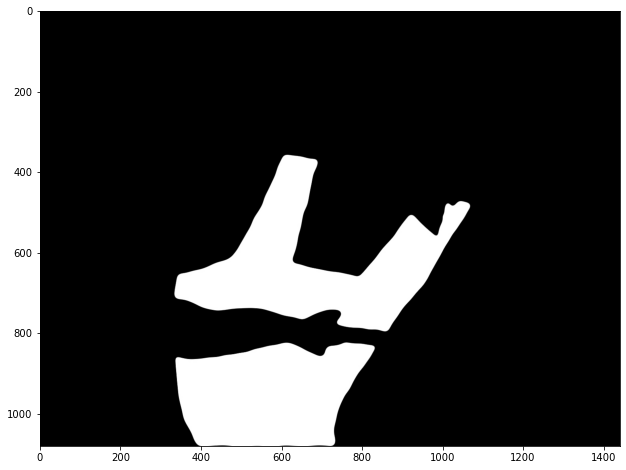

In [3]:
# open a matte
matte_file = "Comp 2/ShirtMAtte_00000.jpg"
matte_path = shared_datadir / matte_file
matte_image = Image.open(matte_path)
plt.imshow(matte_image)
plt.show()
assert matte_image.mode == "RGB", f"Expect images to be RGB, not {matte_image.mode}"
rgb_array = np.array(matte_image)

In [19]:
# References:
#  https://stackoverflow.com/questions/48585468/vectorize-conways-game-of-life-in-pure-numpy
#  Search this more: cellular automata numpy
#  Also look at image kernels and implementing guassian, etc blur
#  Also look for libraries
#  https://datacarpentry.org/image-processing/08-edge-detection/
#  https://jessicastringham.net/2017/12/31/stride-tricks/ -- Implementing convolutions with stride_tricks
#  https://setosa.io/ev/image-kernels/


INFO:root:Finding distances
INFO:root:distance 1
INFO:root:distance 2
INFO:root:distance 3
INFO:root:distance 4
INFO:root:distance 5
INFO:root:distance 6
INFO:root:distance 7
INFO:root:distance 8
INFO:root:distance 9
INFO:root:distance 10
INFO:root:distance 11
INFO:root:distance 12
INFO:root:distance 13
INFO:root:distance 14
INFO:root:distance 15
INFO:root:distance 16
INFO:root:distance 17
INFO:root:distance 18
INFO:root:distance 19
INFO:root:distance 20
INFO:root:distance 21
INFO:root:distance 22
INFO:root:distance 23
INFO:root:distance 24
INFO:root:distance 25
INFO:root:distance 26
INFO:root:distance 27
INFO:root:distance 28
INFO:root:distance 29
INFO:root:distance 30
INFO:root:distance 31
INFO:root:distance 32
INFO:root:distance 33
INFO:root:distance 34
INFO:root:distance 35
INFO:root:distance 36
INFO:root:distance 37
INFO:root:distance 38
INFO:root:distance 39
INFO:root:distance 40
INFO:root:distance 41
INFO:root:distance 42
INFO:root:distance 43
INFO:root:distance 44
INFO:root:dis

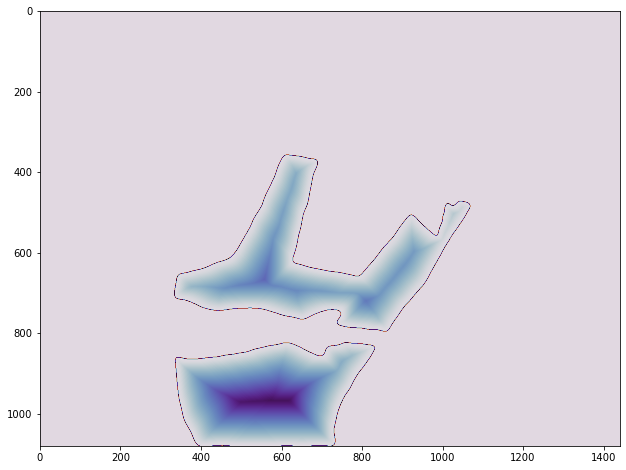

In [4]:
edge_distance = find_edge_distance(matte_path)
plt.imshow(np.where(edge_distance==0,256,edge_distance),cmap='twilight', vmin=0, vmax=255) # https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.show()

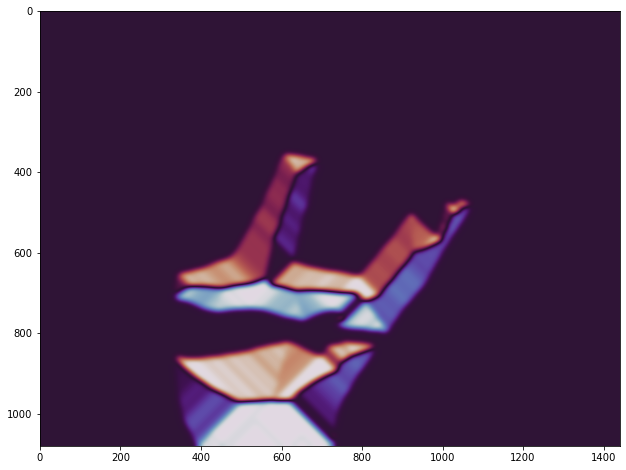

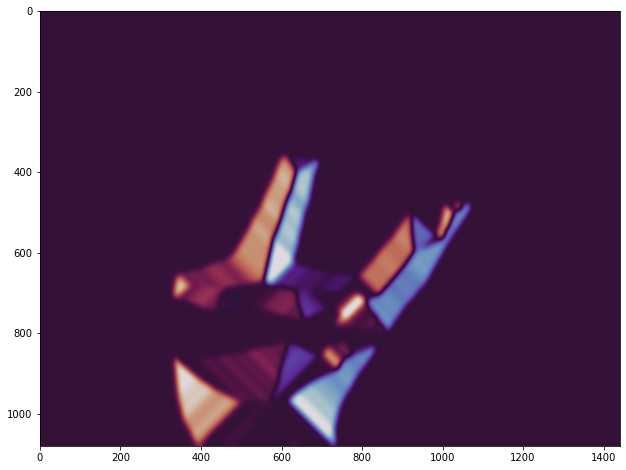

In [7]:
directions = find_directions(edge_distance)
plt.imshow(directions[0],cmap='twilight')
plt.show()
plt.imshow(directions[1],cmap='twilight')
plt.show()

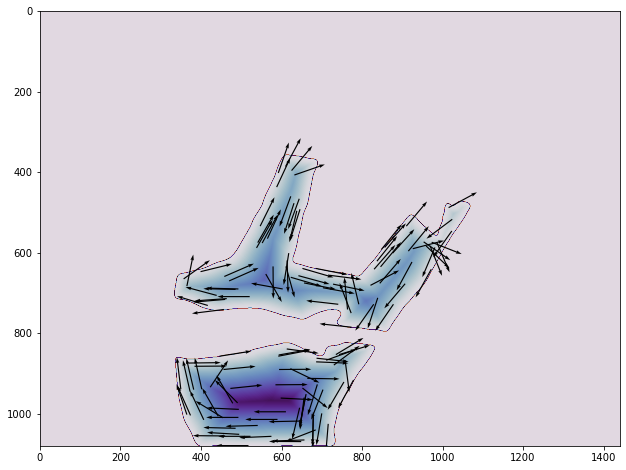

In [14]:
import math

random_count = 1000

rng = np.random.RandomState(seed=231) # random number generator
rand_x=rng.randint(0,edge_distance.shape[0],random_count)
rand_y=rng.randint(0,edge_distance.shape[1],random_count)
plt.imshow(np.where(edge_distance==0,256,edge_distance),cmap='twilight', vmin=0, vmax=255)
for i in range(random_count):
    x,y = rand_x[i],rand_y[i]
    v = edge_distance[x,y]
    if v==0:
        continue
    dx,dy = directions[0][x,y],directions[1][x,y]
    angle = math.atan2(dy,dx)-math.pi/2
    dxr,dyr = math.cos(angle),math.sin(angle)
    # print(x,y,v,dx,dy)
    # plt.plot(y,x,"o")
    plt.quiver(y,x,-dyr,-dxr,angles='xy',width=.002)
plt.show()    

(3675,)
(array([ 386,  386,  386, ..., 1055, 1055, 1055], dtype=int64), array([627, 628, 629, ..., 572, 573, 574], dtype=int64))


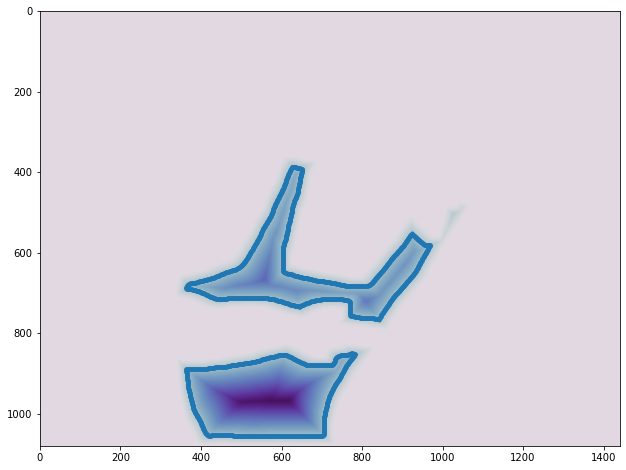

In [29]:
# Where to put next EDGE brushstroke.

how_far_in = 25 # This could be a little random and based on width of stroke

candidates = np.nonzero(edge_distance==how_far_in)
print(candidates[0].shape)
print(candidates)

plt.imshow(edge_distance,cmap='twilight', vmin=0, vmax=255)
plt.plot(candidates[1],candidates[0],".")
plt.show()

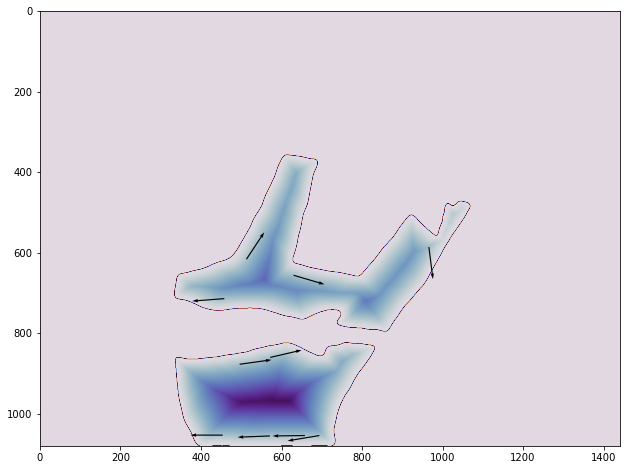

In [123]:
random_count = 10

rng = np.random.RandomState(seed=231) # random number generator
plt.imshow(np.where(edge_distance==0,256,edge_distance),cmap='twilight', vmin=0, vmax=255)
for _ in range(random_count):
    i = rng.choice(len(candidates[1]))
    x,y = candidates[0][i],candidates[1][i]
    dx,dy = directions[0][x,y],directions[1][x,y]
    angle = math.atan2(dy,dx)-math.pi/2
    dxr,dyr = math.cos(angle),math.sin(angle)
    #print(x,y,v,dx,dy)
    #plt.plot(y,x,"o")
    plt.quiver(y,x,-dyr,-dxr,angles='xy',width=.002)
plt.show() 

In [124]:
rng = np.random.RandomState(seed=231) # random number generator

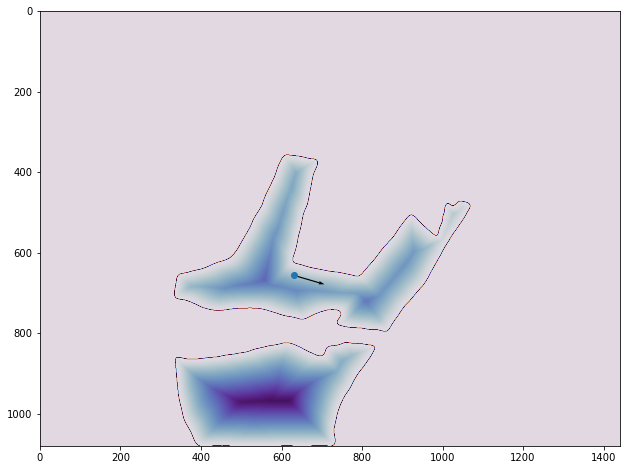

In [128]:
plt.imshow(np.where(edge_distance==0,256,edge_distance),cmap='twilight', vmin=0, vmax=255)
i = rng.choice(len(candidates[1]))
x,y = candidates[0][i],candidates[1][i]
dx,dy = directions[0][x,y],directions[1][x,y]
angle = math.atan2(dy,dx)-math.pi/2
dxr,dyr = math.cos(angle),math.sin(angle)
#print(x,y,v,dx,dy)
plt.plot(y,x,"o")
plt.quiver(y,x,-dyr,-dxr,angles='xy',width=.002)
plt.show() 

RGBA


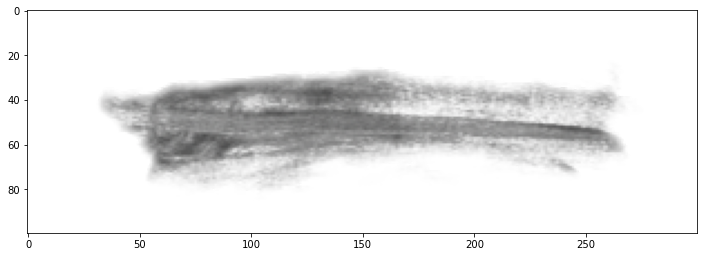

In [57]:
brush_file = "brushes/PaintStrokes (0-00-00-04).png"
brush_path = shared_datadir / brush_file
brush_image = Image.open(brush_path)
assert brush_image.mode == "RGBA", f"Expect images to be RGBA, not {brush_image.mode}"
print(brush_image.mode)
plt.imshow(brush_image)

In [130]:
def composite(base_image, sprite, x, y, angle_degrees, sprite_factor, draw_debug_line=False):
    #angle_degrees = math.degrees(angle_radians)-90
    #https://stackoverflow.com/questions/37941648/unable-to-crop-away-transparency-neither-pil-getbbox-nor-numpy-are-working
    angle_degrees = angle_degrees % 360.0

    if sprite_factor != 1:
        sprite = sprite.resize((int(sprite.width*sprite_factor+.5),int(sprite.height*sprite_factor+.5)),resample=Image.LANCZOS)

    sprite = sprite.crop(sprite.convert("RGBA").getbbox())
    result = base_image.copy()

    x0 = x + math.cos(math.radians(angle_degrees))*sprite.width * -.5
    y0 = y + math.sin(math.radians(angle_degrees))*sprite.width * -.5

    x2 = x + math.cos(math.radians(angle_degrees))*sprite.width * .5
    y2 = y + math.sin(math.radians(angle_degrees))*sprite.width * .5
    if draw_debug_line:
        draw = Draw(result)
        draw.line([(x0,y0),(x2,y2)],fill="red",width=sprite.height)
    
    
    center0 = [sprite.width/2.0,sprite.height/2.0]
    rot = sprite.rotate(-angle_degrees,expand=True)
    rot = rot.crop(rot.getbbox())
    if 0 <= angle_degrees <= 90:
        center1 = center0
    elif 90 < angle_degrees <= 180:
        center1 = [rot.width,0]
    elif 180 < angle_degrees <= 270:
        center1 = [rot.width, rot.height]
    elif 270 < angle_degrees <= 360:
        center1 = [0, rot.height]
    else:
        raise ValueError(f"Don't know angle {angle_degrees} degrees")
        
    #result.paste(rot,(int(x-center1[0]+.5),int(y-center1[1]+.5)),mask=rot)
    x1 = int(x-center1[0]+.5)
    y1 = int(y-center1[1]+.5)
    result.paste(rot,(x1,y1),mask=rot)

    return result

In [142]:
math.degrees(math.atan2(dy,dx))

16.32238692129988

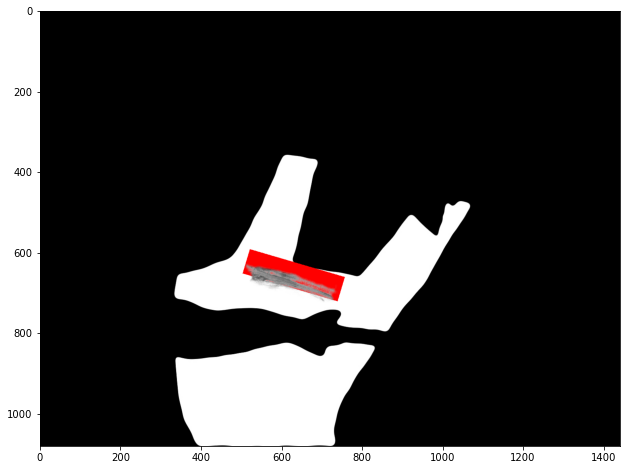

In [144]:
im1 = composite(matte_image,brush_image,y,x,-math.degrees(math.atan2(dy,dx)),sprite_factor=1,draw_debug_line=True)
plt.imshow(im1)
plt.show()

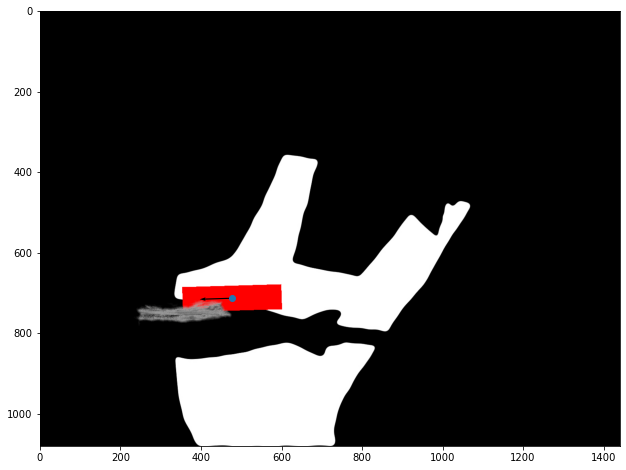

In [155]:
i = rng.choice(len(candidates[1]))
x,y = candidates[0][i],candidates[1][i]
dx,dy = directions[0][x,y],directions[1][x,y]
angle = math.atan2(dy,dx)-math.pi/2
dxr,dyr = math.cos(angle),math.sin(angle)
im1 = composite(matte_image,brush_image,y,x,-math.degrees(math.atan2(dy,dx)),sprite_factor=1,draw_debug_line=True)
plt.imshow(im1)
plt.plot(y,x,"o")
plt.quiver(y,x,-dyr,-dxr,angles='xy',width=.002)